# Projet Ingénierie Logicielle pour l’IA
> Gwenaelle Cadic, Charly Malamaire & Lorraine Vanel

# Exercice 1

Nos prédécesseurs ont testé 4 metrics différentes:


*   Loss: 0.015
*   Precision : 0.883
*   Recall: 0.665
*   F1 : 0.758

Nous pourrions nous faire la remarque que l’analyse est très légère, il nous manque une justification du choix de celles-ci par exemple. Est-ce que l’absence de l’Accuracy vient du fait qu’elle n’aurait aucun intérêt car le dataset n’est pas équilibré? D’ailleurs quand est-il du dataset en lui-même? Nous n’avons aucune information.

>Intéressons-nous aux résultats donnés:
La **loss** quantifie la différence entre l’attendu et la prédiction, le résultat est très bon.
La **précision** quantifie la proportion des positifs annoncés qui étaient réellement positifs, tandis que le **recall** quantifie la proportion des positifs annoncés parmi les réponses réellement positives.

Dans notre cas, nous ne voulons pas prendre le risque de donner une information erronée. Ce qui veut dire que nous voulons être sûr que lorsque nous donnons une information, celle-ci soit exacte avec une forte probabilité. Ce qui en terme de metrics voudrait dire une très forte précision et un recall plus bas.
Nous avons donc deux metrics qui font sens par rapport à l’objectif global mais qui pourrait encore être améliorés avec une amélioration supplémentaire de la précision qui entrainera obligatoirement une baisse du recall
Le score F-1 permet de représenter l’harmonie entre le recall et la précision. Cette metric semble peu pertinente, mais son existence nous permet de confirmer la remarque ci-dessus, c’est-à-dire qu’on peut encore augmenter la précision.

Etant donné de ce que nous savons, nous estimons qu’il est encore nécessaire d’obtenir des données sur le dataset en lui même
Visualisations:
visualiser la répartition du dataset pour prouver que regarder l'accuracy n'est pas le plus pertinent (nb total d’éléments, nb d’éléments par classe, % par classe).
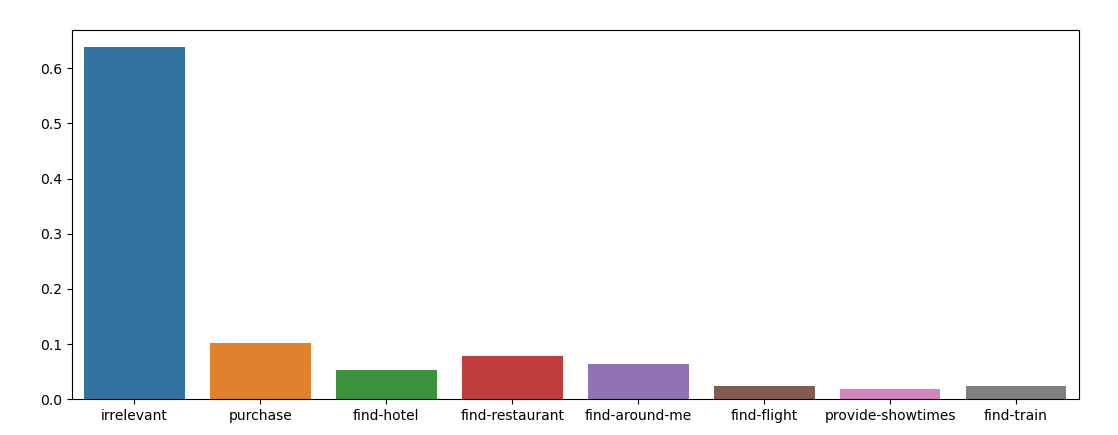

Dans le code ci-dessous, vous pourrez trouver des visualisation de la roc curve  et d'une matrice de confusion.

In [ ]:
#IMPORTS

#!pip  install -r requirements.txt

import json
import urllib.parse
import urllib.request
import seaborn as sns
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn.metrics
from sklearn.preprocessing import OneHotEncoder
sns.set(rc={'axes.facecolor':'darkgray', 'figure.facecolor':'lightgray'})
plt.rcParams["figure.figsize"]=12,12

In [ ]:
with open('training_set.json', encoding="utf-8") as trainF:
    train = json.loads(trainF.read())
with open('testing_set.json', encoding="utf-8") as testF:
    test = json.loads(testF.read())

sentence = [test[i].get("sentence") for i in range (len(test))]
intents = [test[i].get("intent") for i in range (len(test))]



In [ ]:
data = []
probas =[]


In [ ]:
for i in range(len(sentence)):
    conc = {'sentence' : sentence[i]}
    out = urllib.parse.urlencode(conc)
    b = 'http://127.0.0.1:8000/api/intent?'+ out
    a = urllib.request.urlopen(b)
    rawdata= (json.load(a))
    data.append(list(rawdata.keys())[list(rawdata.values()).index(max(rawdata.values()))])

    probas.append(list(rawdata.values()))
  


 Répartition des valeurs de probabilités observées par classe : 
 [0.02997748 0.58771524 0.02771703 0.08357995 0.11292676 0.07345207
 0.02486785 0.05976362]


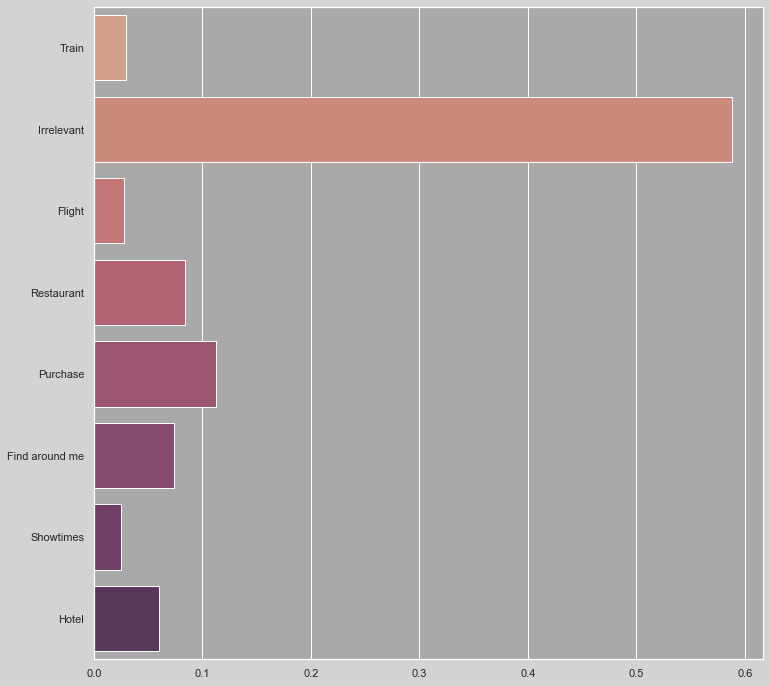

In [ ]:
keys = list(ct.keys())
vals = list(ct.values())
vals = [i/sum(vals) for i in vals]
trainintents = [train[i].get("intent") for i in range(len(train))]
ct = Counter(trainintents)

rep = np.mean(probas, axis = 0)

print(" Répartition des valeurs de probabilités observées par classe : \n" , rep)
sns.barplot(x= rep, y = ["Train", "Irrelevant", "Flight", "Restaurant", "Purchase", "Find around me", "Showtimes", "Hotel"], saturation = 0.6, palette="flare" )



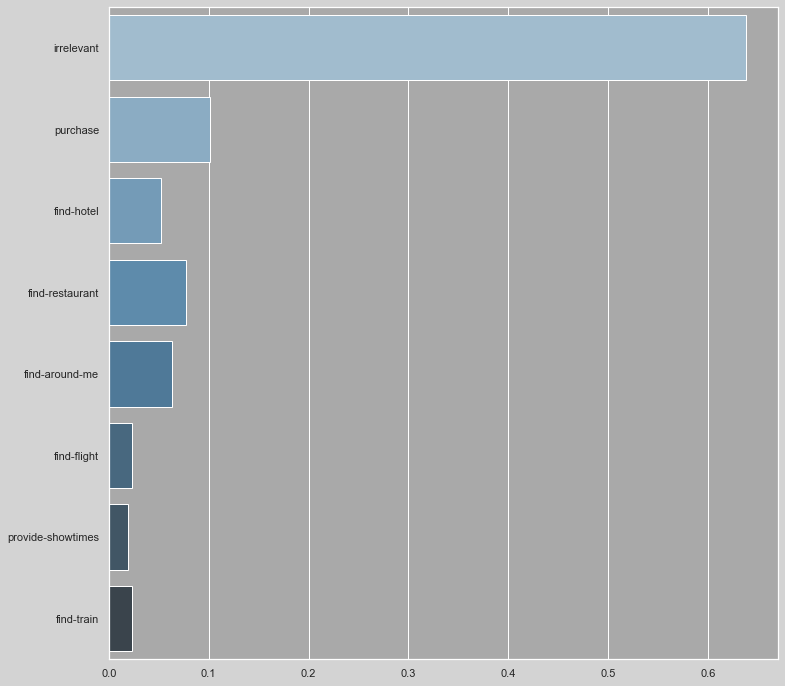

In [ ]:

sns.barplot(x=vals, y=keys ,saturation=0.6, orient="h", palette="Blues_d")
plt.show()

In [ ]:
# accuracy des données testées
accuracy = 0
for i in range(len(data)):
    accuracy += (data[i]==intents[i])
accuracy /= len(data)
print("Accuracy du modèle : " ,  accuracy)

Accuracy du modèle :  0.8046948356807512


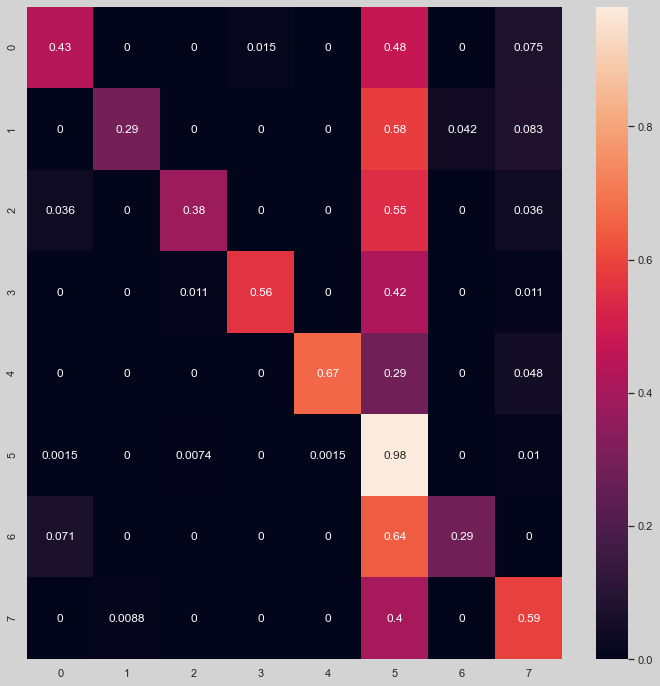

In [ ]:
# Matrice de confusion

conf_mat= sklearn.metrics.confusion_matrix(intents, data, normalize='true')
sns.heatmap(conf_mat, annot=True)
plt.show()

In [ ]:
f1 = sklearn.metrics.f1_score(intents, data, zero_division=1, average=None)
fb = sklearn.metrics.fbeta_score(intents, data, beta= 0.1, zero_division=1, average=None)
kappa = sklearn.metrics.cohen_kappa_score(intents, data,sample_weight=None)

print("F1- Score : \n\n", f1, "\n")
print("Fβ- Score pour β=0.1 :\n\n ", fb, "\n")
print("Kappa de Cohen : ", kappa)


F1- Score : 

 [0.58       0.4375     0.51219512 0.71232877 0.77777778 0.87467018
 0.42105263 0.67336683] 

Fβ- Score pour β=0.1 :

  [0.86991387 0.85800971 0.76987296 0.973855   0.92965155 0.79174007
 0.78599222 0.78558161] 

Kappa de Cohen :  0.5952715911789962


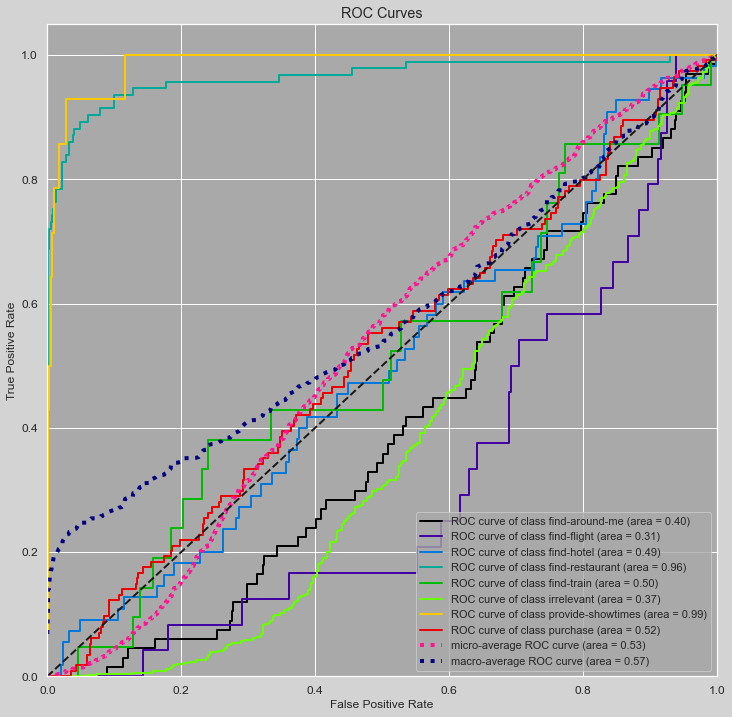

In [ ]:
y_true = intents 
y_probas = probas 
skplt.metrics.plot_roc(y_true, y_probas)
plt.legend(loc="lower right")

plt.show()


# Exercice 2

En étudiant les valeurs moyennes pour chaque classe renvoyées par le softmax, il apparaît que celles-ci sont particulièrement hétérogènes. Sélectionner un unique seuil pour la totalité des classes n’aurait de sens que dans le cas inverse où les distributions des différentes intentions seraient proches.

En l’occurrence, cela conduirait à ne plus du tout détecter certaines intentions dont les valeurs de certitude n'atteindront jamais ou presque le seuil requis.

Une optimisation potentielle pourrait être de définir un threshold spécifique à chaque classe plutôt que globalement (liste avec un seuil par classe s’adaptant aux valeurs moyennes prises par les prédictions). 

Cela permettrait ainsi d’optimiser localement la précision, sans compromettre la détection dans d’autres classes - une classe avec globalement un fort taux de confiance pourrait par exemple bénéficier d’un seuil plus bas éliminant davantage de faux positifs, sans toucher aux autres seuils.